<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day13_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
!pip install statsmodels -q

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"

df = pd.read_csv(url)

print(f"{df.shape[0]} months of data")
df.head()

144 months of data


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df.columns = ['month', 'passengers']

#convert to datetime
df['month'] = pd.to_datetime(df['month'])
df.set_index('month', inplace=True)

print(f"Data Range: {df.index.min()} to {df.index.max()}")
print(f"Frequency: Monthly")
print(f"Total Obbservations: {len(df)}")
df.head()

Data Range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00
Frequency: Monthly
Total Obbservations: 144


,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
print(df['passengers'].describe())

count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: passengers, dtype: float64


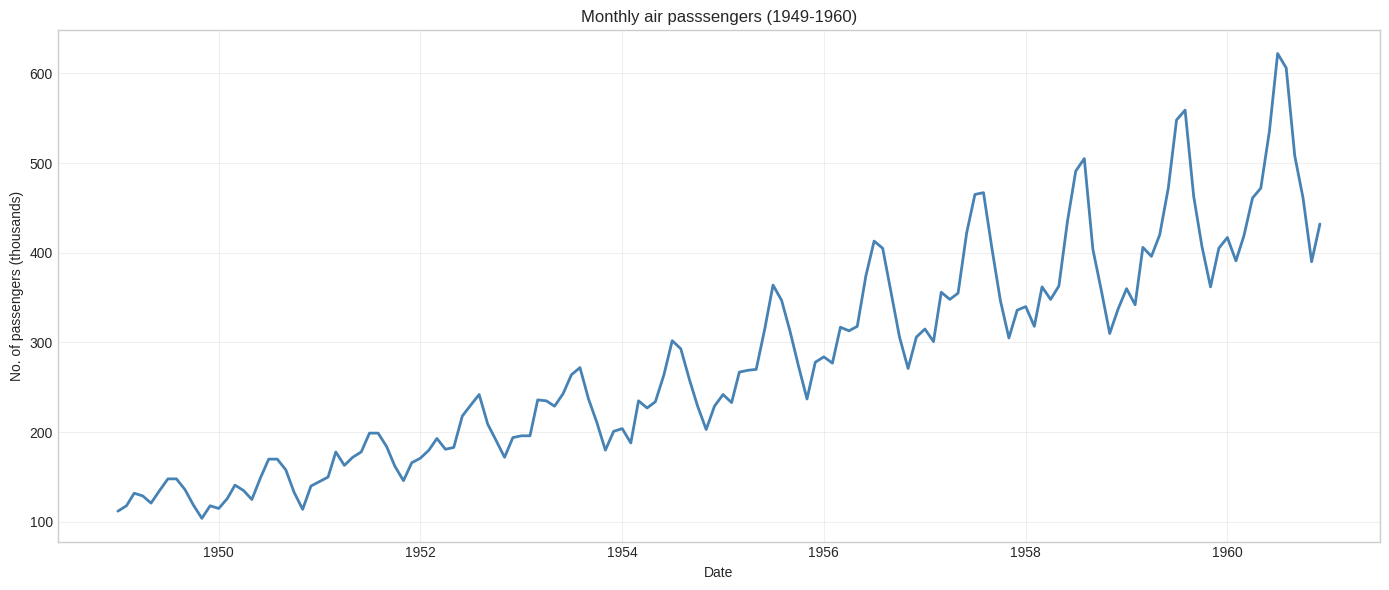

In [6]:
#visualize the time series
fig, ax =plt.subplots(figsize=(14, 6))

ax.plot(df.index, df['passengers'], linewidth=2, color='steelblue')
ax.set_xlabel('Date')
ax.set_ylabel('No. of passengers (thousands)')
ax.set_title("Monthly air passsengers (1949-1960)")

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Time Series Components

Every time series can be decomposed into:

1. **Trend (T):** Long-term increase or decrease
2. **Seasonality (S):** Regular, repeating patterns
3. **Residual (R):** Random noise (what's left over)

Two types of decomposition:
- **Additive:** Y = T + S + R (when seasonal variation is constant)
- **Multiplicative:** Y = T × S × R (when seasonal variation grows with trend)

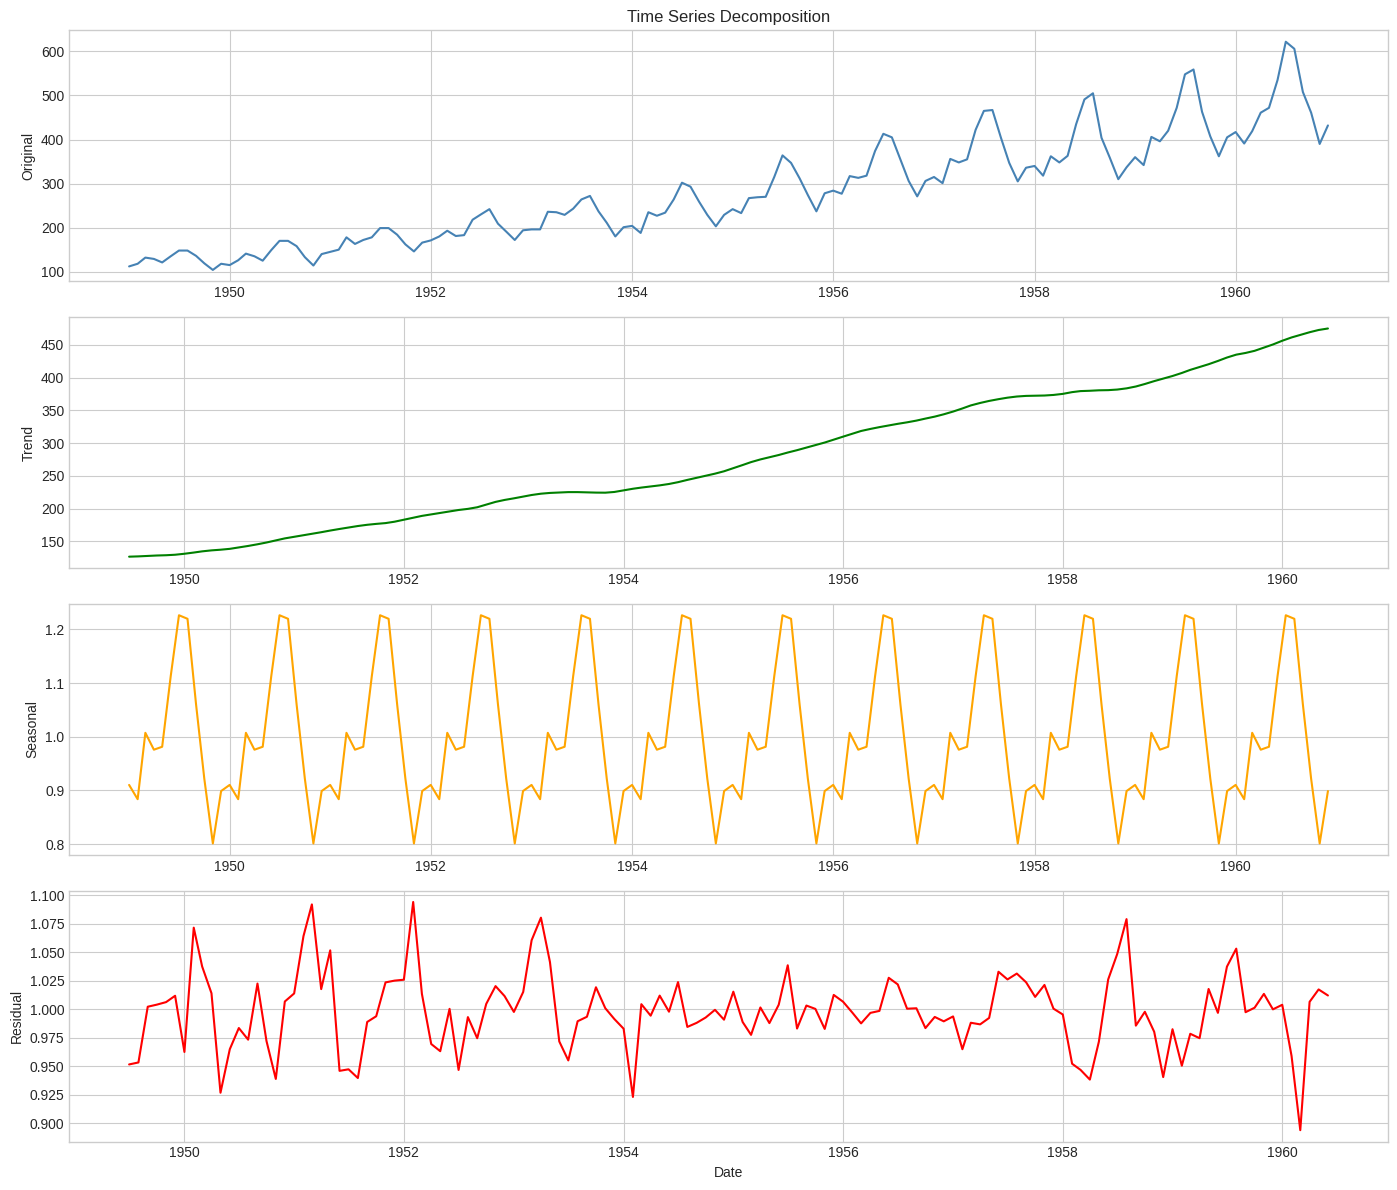

In [7]:
#Decompose the time series
decomposition = seasonal_decompose(df['passengers'], model='multiplicative', period=12)

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

#Original
axes[0].plot(df.index, df['passengers'], linewidth=1.5, color='steelblue')
axes[0].set_ylabel("Original")
axes[0].set_title("Time Series Decomposition")

#Trend
axes[1].plot(df.index, decomposition.trend, linewidth=1.5, color='green')
axes[1].set_ylabel("Trend")

#Seasonal
axes[2].plot(df.index, decomposition.seasonal, linewidth=1.5, color='orange')
axes[2].set_ylabel("Seasonal")

#Residual
axes[3].plot(df.index, decomposition.resid, linewidth=1.5, color='r')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

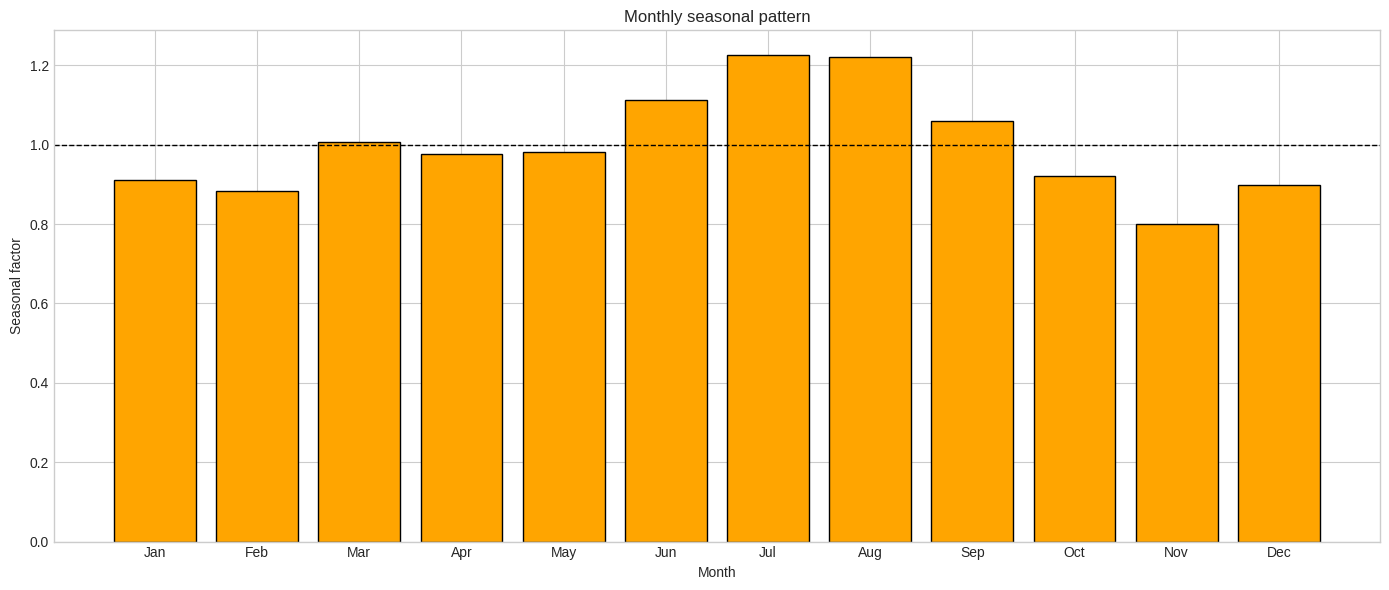

In [8]:
#extracting and examining seasonal pattern
seasonal_pattern = decomposition.seasonal[:12]

fig, ax = plt.subplots(figsize=(14, 6))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.bar(months, seasonal_pattern.values, color='orange', edgecolor='black')
ax.axhline(y=1.0, color='black', linestyle='--',  linewidth=1)
ax.set_xlabel("Month")
ax.set_ylabel("Seasonal factor")
ax.set_title("Monthly seasonal pattern")

plt.tight_layout()
plt.show()

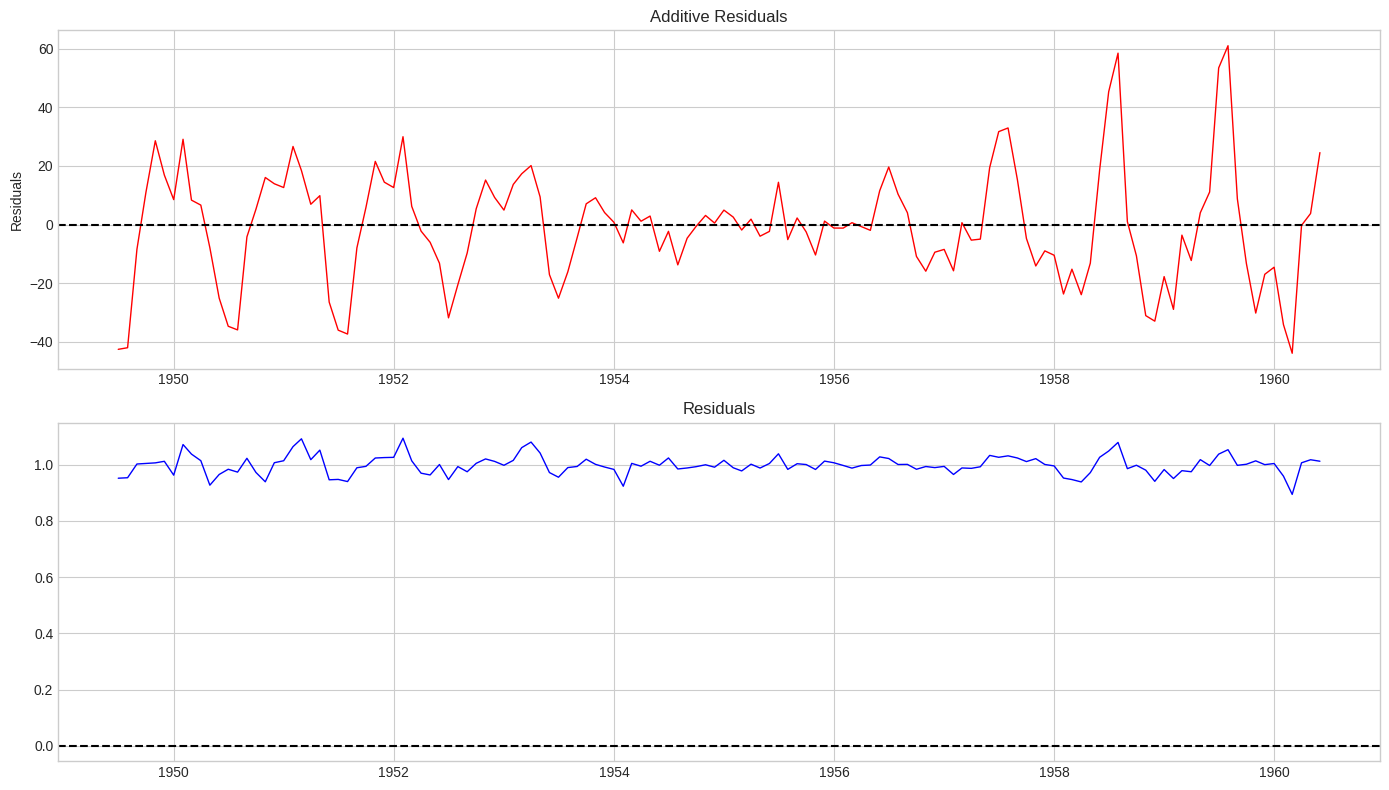

In [9]:
#Compare additive vs multilpicative decomposition
decomp_additive = seasonal_decompose(df['passengers'], model='additive', period=12)
decomp_multiplicative = seasonal_decompose(df['passengers'], model='multiplicative', period=12)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

#Additive REsiduals
axes[0].plot(df.index, decomp_additive.resid, color='r', linewidth=1)
axes[0].set_title("Additive Residuals")
axes[0].set_ylabel("Residuals")
axes[0].axhline(y=0, linestyle='--', color='black')

#Multiplicative residuals
axes[1].plot(df.index, decomp_multiplicative.resid, color='blue', linewidth=1)
axes[1].set_title("Multiplicative Residuals")
axes[1].set_title("Residuals")
axes[1].axhline(y=0, linestyle='--', color='black')

plt.tight_layout()
plt.show()

Use multiplicative when seasonal variation grows with trend

Stationarity

**Stationary series:** Statistical properties don't change over time
- Constant mean
- Constant variance
- No trend
- No seasonality

**Why it matters:** Most forecasting models (ARIMA, etc.) assume stationarity!

**Our data:** NOT stationary (has trend + seasonality)

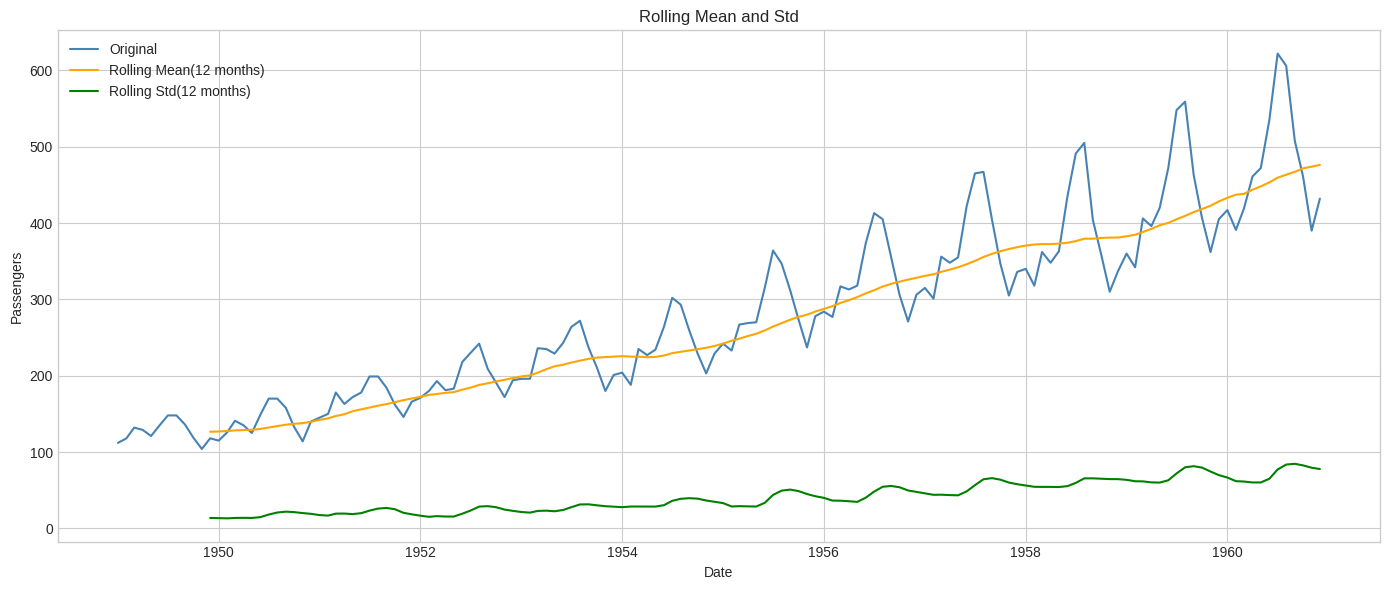

In [10]:
#visual check
rolling_mean = df['passengers'].rolling(window=12).mean()
rolling_std = df['passengers'].rolling(window=12).std()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, df['passengers'], label='Original', color='steelblue')
ax.plot(df.index, rolling_mean, label='Rolling Mean(12 months)', color='orange')
ax.plot(df.index, rolling_std, label='Rolling Std(12 months)', color='green')

ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.set_title('Rolling Mean and Std')
ax.legend()

plt.tight_layout()
plt.show()

In [11]:
#Statistical Test: Augmented Dickey-Fuller (ADF)
def adf_test(series, name=''):
  """Perform Augmented Dickey-Fuller test"""
  result = adfuller(series.dropna(), autolag='AIC')

  print(f"ADF Results:  {name}")
  print(f"Test Statistic: {result[0]:.4f}")
  print(f"p-value: {result[1]:.4f}")
  print(f"Logs used: {result[2]}")
  print(f"Observations: {result[3]}")
  for key, value in result[4].items():
    print(f"   {key} {value:.4f}")

  if result[1] < 0.05:
    print(f"Stationary (p-value < 0.05)")
  else:
    print(f"Non-Stationary (p-value >= 0.05)")

#Test orginnal series
adf_test(df['passengers'], '(Original Series)')

ADF Results:  (Original Series)
Test Statistic: 0.8154
p-value: 0.9919
Logs used: 13
Observations: 130
   1% -3.4817
   5% -2.8840
   10% -2.5788
Non-Stationary (p-value >= 0.05)


In [12]:
#How to make it staionary

#Method 1: Differencing (remove trend)
df['passengers_diff'] = df['passengers'].diff()

#Method 2: Seasonal differencing (remove seasonality)
df['passengers_seasonal_diff'] = df['passengers'].diff(12)

#method 3: Both (difference and trend)
df['passengers_both_diff'] = df['passengers'].diff(12).diff()

#Method 4: Log transform + Difference
df['passengers_log'] = np.log(df['passengers'])
df['passengers_log_diff'] = df['passengers_log'].diff()

print("Transformations created")

Transformations created


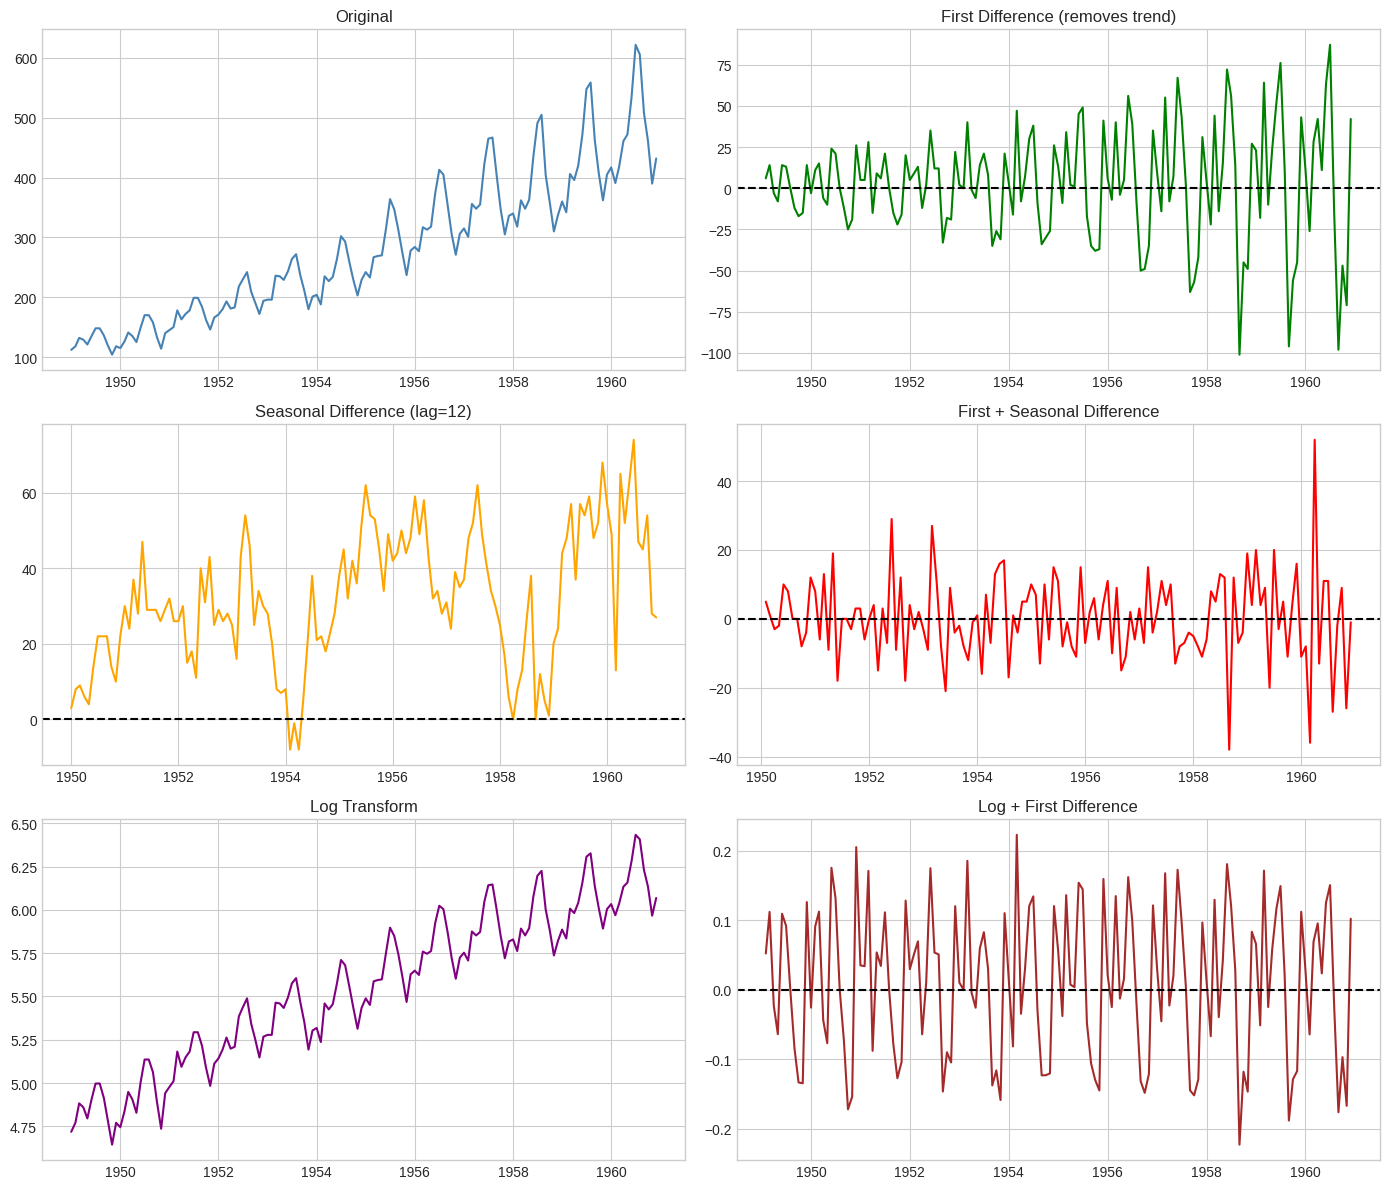

In [13]:
# Visualize transformations
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Original
axes[0, 0].plot(df.index, df['passengers'], color='steelblue')
axes[0, 0].set_title('Original')

# First difference
axes[0, 1].plot(df.index, df['passengers_diff'], color='green')
axes[0, 1].set_title('First Difference (removes trend)')
axes[0, 1].axhline(y=0, color='black', linestyle='--')

# Seasonal difference
axes[1, 0].plot(df.index, df['passengers_seasonal_diff'], color='orange')
axes[1, 0].set_title('Seasonal Difference (lag=12)')
axes[1, 0].axhline(y=0, color='black', linestyle='--')

# Both
axes[1, 1].plot(df.index, df['passengers_both_diff'], color='red')
axes[1, 1].set_title('First + Seasonal Difference')
axes[1, 1].axhline(y=0, color='black', linestyle='--')

# Log transform
axes[2, 0].plot(df.index, df['passengers_log'], color='purple')
axes[2, 0].set_title('Log Transform')

# Log + diff
axes[2, 1].plot(df.index, df['passengers_log_diff'], color='brown')
axes[2, 1].set_title('Log + First Difference')
axes[2, 1].axhline(y=0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

In [14]:
#Tesing stationarity of the transformed series

transforms = [
    ('First Difference', df['passengers_diff']),
    ('Seasonal Difference', df['passengers_seasonal_diff']),
    ('First + Seasonal Difference', df['passengers_both_diff']),
    ('Log + First Difference', df['passengers_log_diff'])
]

results = []
for name, series in transforms:
  result = adfuller(series.dropna(), autolag="AIC")
  is_stationary = result[1] < 0.05
  results.append({
      'Transform': name,
      'ADF Statistic': result[0],
      'p-value': result[1],
      'Is Stationary': "Yes" if is_stationary else "No"
  })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

                  Transform  ADF Statistic      p-value Is Stationary
           First Difference      -2.829267 5.421329e-02            No
        Seasonal Difference      -3.383021 1.155149e-02           Yes
First + Seasonal Difference     -15.595618 1.856512e-28           Yes
     Log + First Difference      -2.717131 7.112055e-02            No


Lag Features

**Lag features:** Use past values to predict future values.

- Lag 1 = Yesterday's value
- Lag 12 = Same month last year (for monthly data)

In [15]:
#create lag features
df_features = df[['passengers']].copy()

#lag features
df_features['lag_1'] = df_features['passengers'].shift(1)
df_features['lag_2'] = df_features['passengers'].shift(2)
df_features['lag_3'] = df_features['passengers'].shift(3)
df_features['lag_6'] = df_features['passengers'].shift(6)
df_features['lag_12'] = df_features['passengers'].shift(12)  # Same month last year

print("Lag features")
df_features.head(15)

Lag features


,passengers,lag_1,lag_2,lag_3,lag_6,lag_12
month,,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,112.0,NaN,NaN,NaN,NaN
1949-03-01,132,118.0,112.0,NaN,NaN,NaN
1949-04-01,129,132.0,118.0,112.0,NaN,NaN
1949-05-01,121,129.0,132.0,118.0,NaN,NaN
1949-06-01,135,121.0,129.0,132.0,NaN,NaN
1949-07-01,148,135.0,121.0,129.0,112.0,NaN
1949-08-01,148,148.0,135.0,121.0,118.0,NaN
1949-09-01,136,148.0,148.0,135.0,132.0,NaN


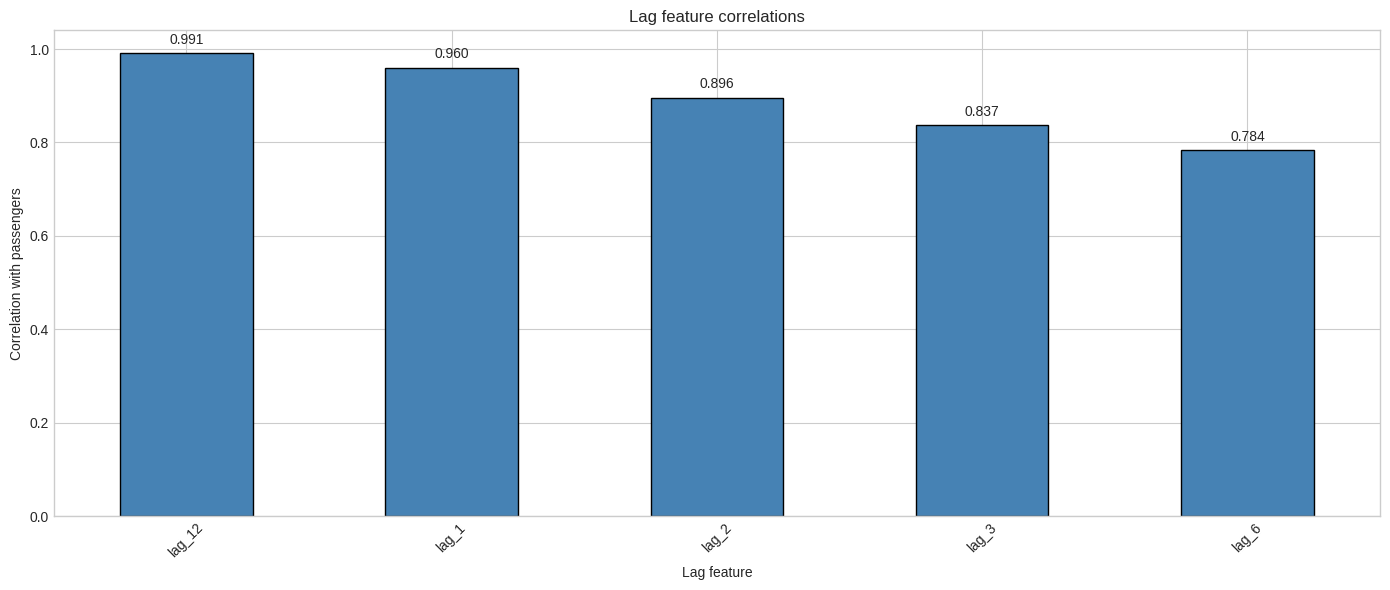

In [16]:
#Correlation of lag features with target
correlations = df_features.corr()['passengers'].drop('passengers').sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))

correlations.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Lag feature')
ax.set_ylabel('Correlation with passengers')
ax.set_title('Lag feature correlations')
ax.axhline(y=0, linewidth=0.5, color='black')

#Add values on bars
for i, v in enumerate(correlations):
  ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Lag 12(same month last year) has the highest correlation

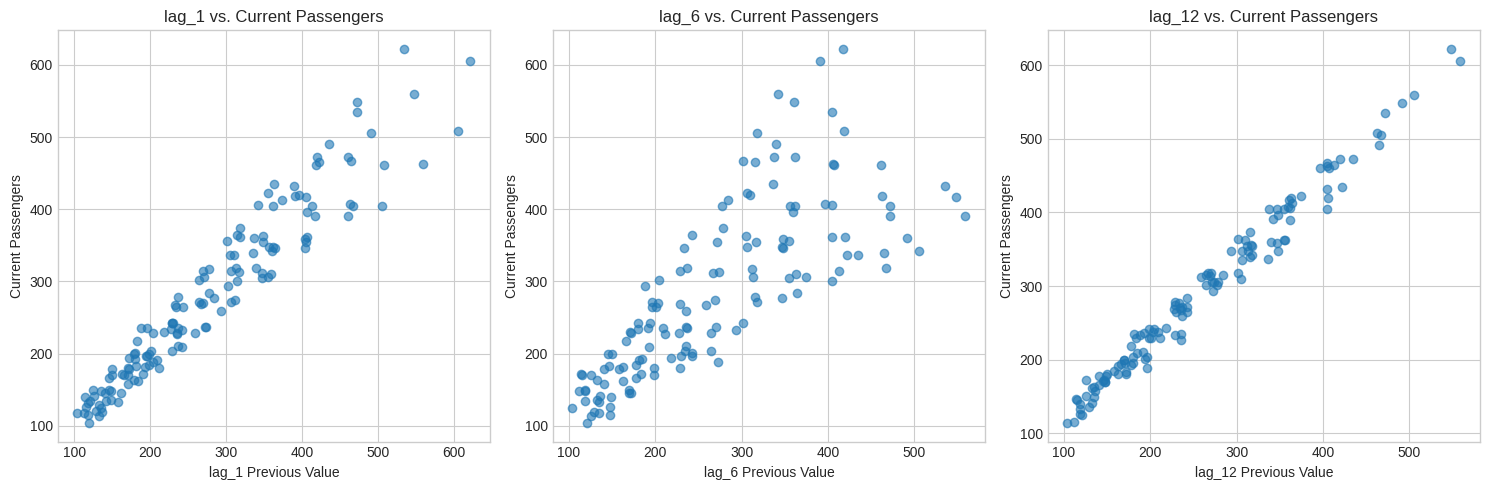

In [17]:
from numpy.random.mtrand import f
#Scatterplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax,  lag in zip(axes, ['lag_1', 'lag_6', 'lag_12']):
  ax.scatter(df_features[lag], df_features['passengers'], alpha=0.6)
  ax.set_xlabel(f"{lag} Previous Value")
  ax.set_ylabel("Current Passengers")
  ax.set_title(f"{lag} vs. Current Passengers")

plt.tight_layout()
plt.show()

Rolling Statistics

In [18]:
#create rolling features
df_features['rolling_mean_3'] = df_features['passengers'].rolling(window=3).mean()
df_features['rolling_mean_6'] = df_features['passengers'].rolling(window=6).mean()
df_features['rolling_mean_12'] = df_features['passengers'].rolling(window=12).mean()

df_features['rolling_std_3'] = df_features['passengers'].rolling(window=3).std()
df_features['rolling_std_12'] = df_features['passengers'].rolling(window=12).std()

df_features['rolling_min_12'] = df_features['passengers'].rolling(window=12).min()
df_features['rolling_max_12'] = df_features['passengers'].rolling(window=12).max()

print("Rolling features")
df_features.tail(10)

Rolling features


,passengers,lag_1,lag_2,lag_3,lag_6,lag_12,rolling_mean_3,rolling_mean_6,rolling_mean_12,rolling_std_3,rolling_std_12,rolling_min_12,rolling_max_12
month,,,,,,,,,,,,,
1960-03-01,419,391.0,417.0,405.0,463.0,406.0,409.000000,400.166667,438.250000,15.620499,61.382741,362.0,559.0
1960-04-01,461,419.0,391.0,417.0,407.0,396.0,423.666667,409.166667,443.666667,35.232561,60.171472,362.0,559.0
1960-05-01,472,461.0,419.0,391.0,362.0,420.0,450.666667,427.500000,448.000000,27.970222,60.184565,362.0,559.0
1960-06-01,535,472.0,461.0,419.0,405.0,472.0,489.333333,449.166667,453.250000,39.929104,65.021849,362.0,559.0
1960-07-01,622,535.0,472.0,461.0,417.0,548.0,543.000000,483.333333,459.416667,75.319320,77.194510,362.0,622.0
1960-08-01,606,622.0,535.0,472.0,391.0,559.0,587.666667,519.166667,463.333333,46.306947,83.630500,362.0,622.0
1960-09-01,508,606.0,622.0,535.0,419.0,463.0,578.666667,534.000000,467.083333,61.719797,84.617276,362.0,622.0
1960-10-01,461,508.0,606.0,622.0,461.0,407.0,525.000000,534.000000,471.583333,73.979727,82.541954,362.0,622.0
1960-11-01,390,461.0,508.0,606.0,472.0,362.0,453.000000,520.333333,473.916667,59.405387,79.502382,390.0,622.0


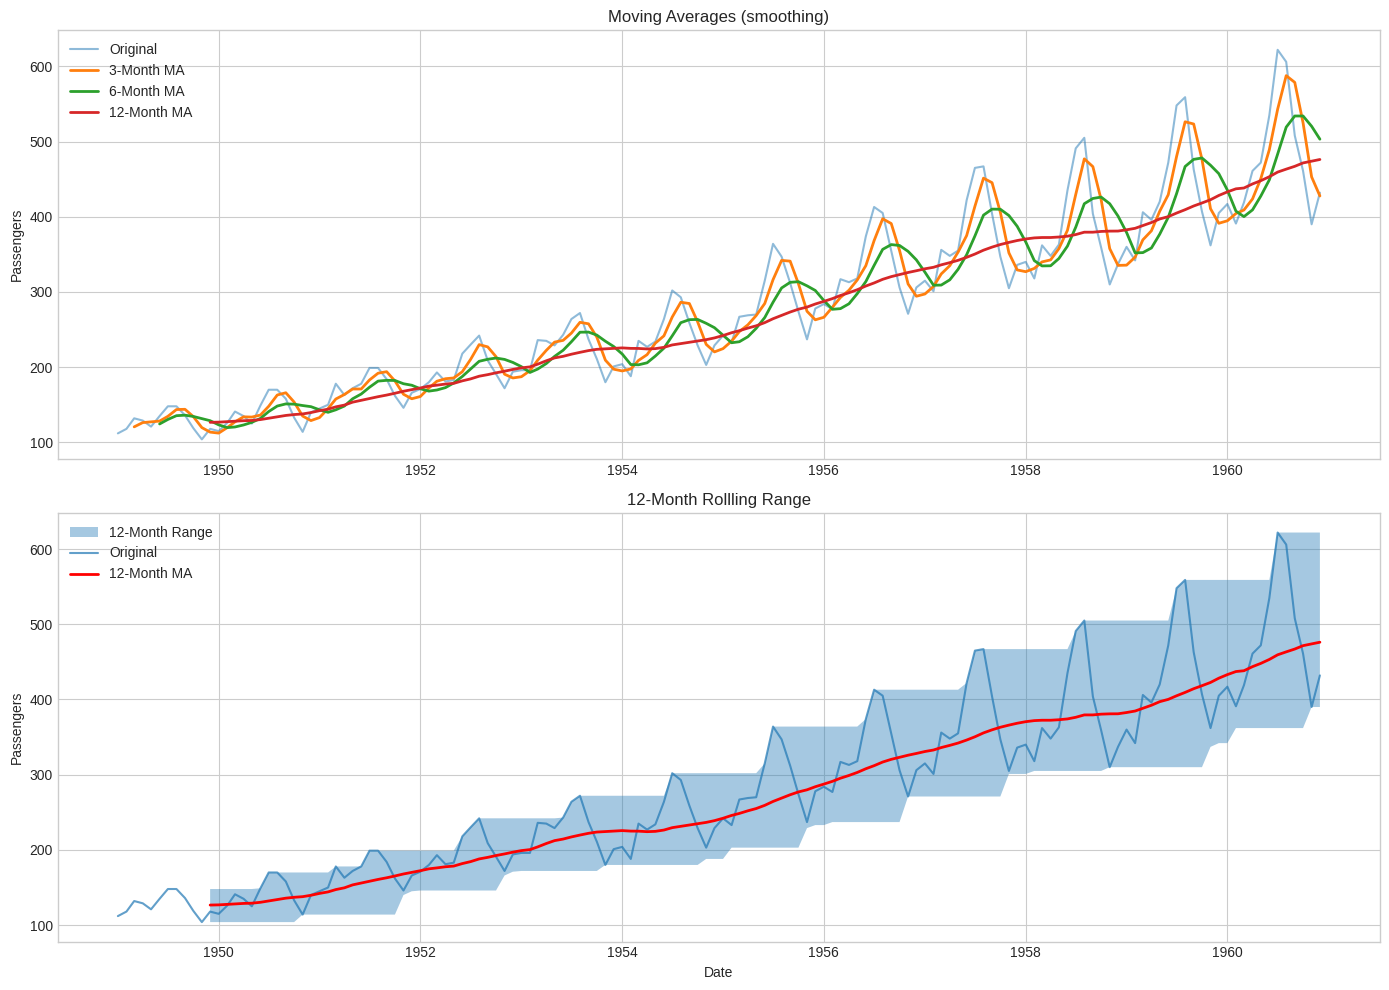

In [19]:
#Visualizing rolling statistics
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

#Rolling_means
axes[0].plot(df_features.index, df_features['passengers'], label='Original', alpha=0.5)
axes[0].plot(df_features.index, df_features['rolling_mean_3'], label='3-Month MA', linewidth=2)
axes[0].plot(df_features.index, df_features['rolling_mean_6'], label='6-Month MA', linewidth=2)
axes[0].plot(df_features.index, df_features['rolling_mean_12'], label='12-Month MA', linewidth=2)
axes[0].set_title("Moving Averages (smoothing)")
axes[0].set_ylabel("Passengers")
axes[0].legend()

#Rolling range
axes[1].fill_between(df_features.index, df_features['rolling_min_12'], df_features['rolling_max_12'],
                     alpha=0.4, label='12-Month Range')
axes[1].plot(df_features.index, df_features['passengers'], label='Original', alpha=0.7)
axes[1].plot(df_features.index, df_features['rolling_mean_12'], label='12-Month MA', color='r', linewidth=2)
axes[1].set_title("12-Month Rollling Range")
axes[1].set_ylabel("Passengers")
axes[1].set_xlabel("Date")
axes[1].legend()

plt.tight_layout()
plt.show()
#

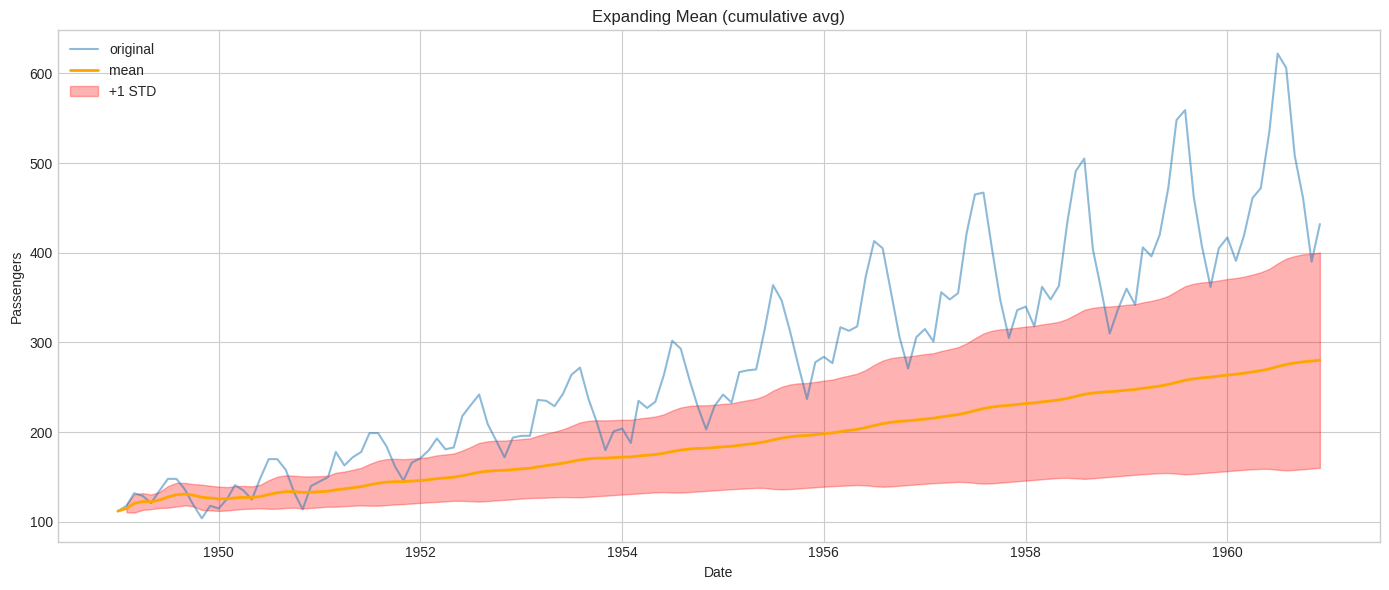

In [20]:
#Expanding statistics
df_features['expanding_mean'] = df_features['passengers'].expanding().mean()
df_features['expanding_std'] = df_features['passengers'].expanding().std()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df_features.index, df_features['passengers'], label='original', alpha=0.5)
ax.plot(df_features.index, df_features['expanding_mean'], label='mean', color='orange', linewidth=2)
ax.fill_between(df_features.index, df_features['expanding_mean'] - df_features['expanding_std'],
                 df_features['expanding_mean'] + df_features['expanding_std'],
                 alpha=0.3, label='+1 STD', color='r')
ax.set_title("Expanding Mean (cumulative avg)")
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.legend()

plt.tight_layout()
plt.show()


##Autocorrelation (ACF) and Partial Autocorrelation (PACF)

**ACF (Autocorrelation Function):** Correlation between a series and its lagged values.

**PACF (Partial Autocorrelation):** Correlation between a series and its lagged values, *after removing intermediate effects*.

**Why they matter:**
- ACF helps identify MA (Moving Average) order
- PACF helps identify AR (Autoregressive) order
- Key tools for ARIMA model selection

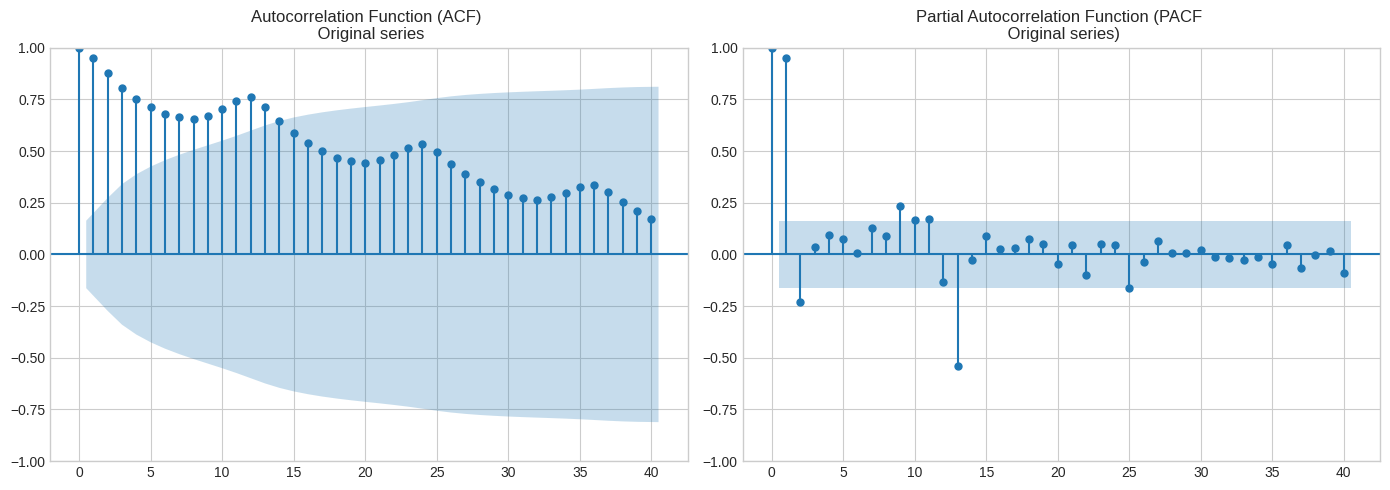

In [21]:
# ACF and PCF of the original series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df['passengers'], lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF) \n Original series")

plot_pacf(df['passengers'], lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF \n Original series)")

plt.tight_layout()
plt.show()

#ACF decays slowly → indicates trend
#Peaks at lag 12, 24, 36 → seasonal pattern

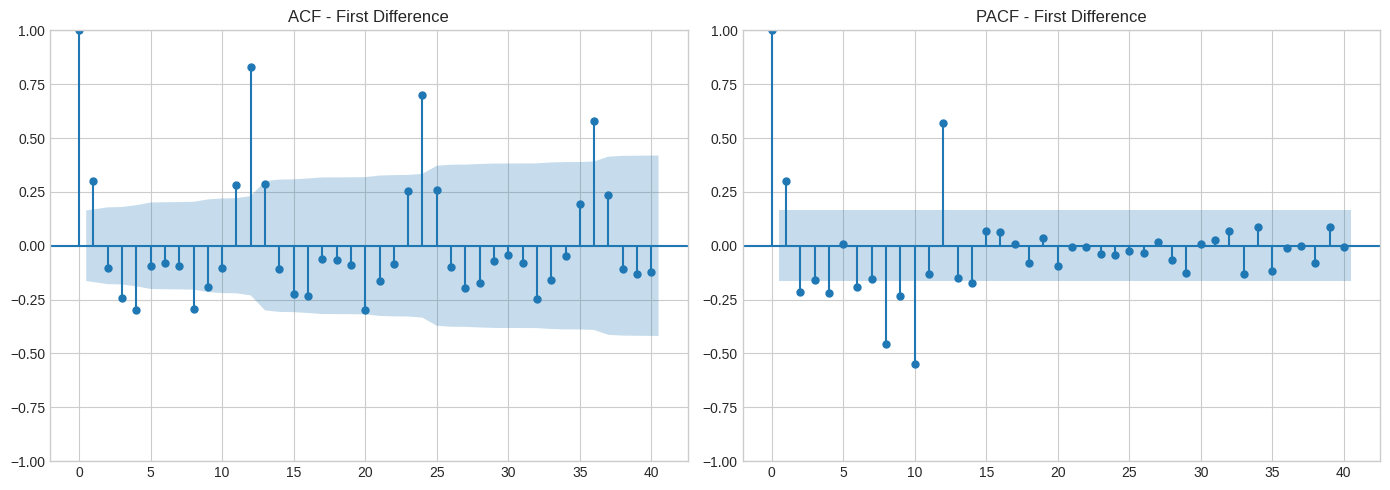

In [22]:
#ACF and PACF of differenced series
diff_series = df['passengers'].diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(diff_series, lags=40, ax=axes[0])
axes[0].set_title("ACF - First Difference")

plot_pacf(diff_series, lags=40, ax=axes[1])
axes[1].set_title("PACF - First Difference")

plt.tight_layout()
plt.show()

#Strong spike at lag 12 → seasonal pattern remains

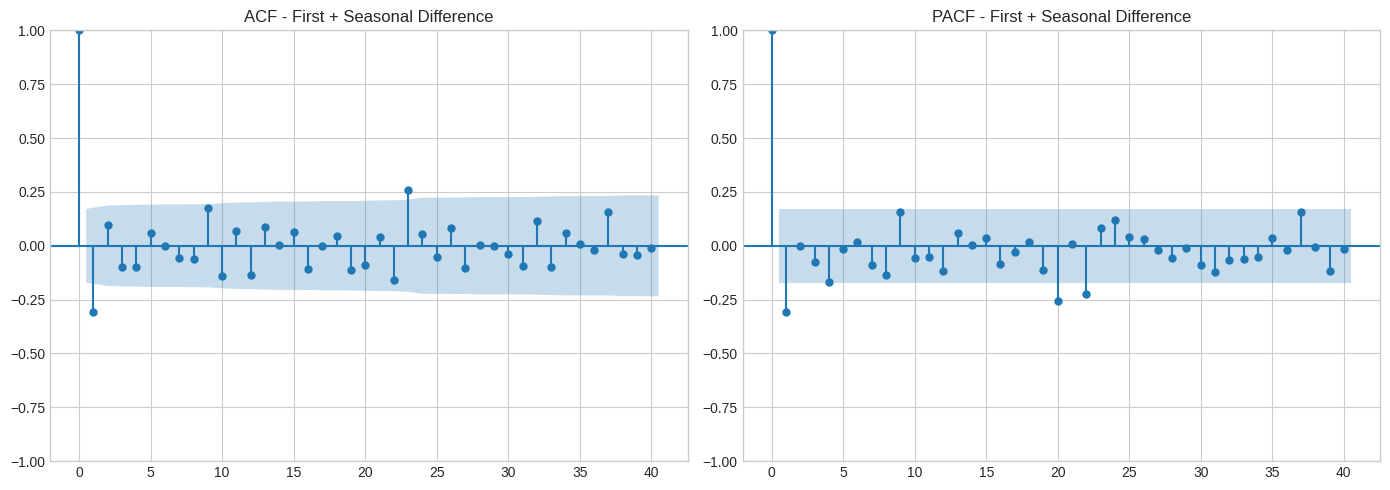

In [23]:
#ACF and PACF at fully differenced series
full_diff = df['passengers'].diff().diff(12).dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(full_diff, lags=40, ax=axes[0])
axes[0].set_title('ACF - First + Seasonal Difference')

plot_pacf(full_diff, lags=40, ax=axes[1])
axes[1].set_title('PACF - First + Seasonal Difference')

plt.tight_layout()
plt.show()

#Ready for ARIMA Modelling


In [24]:
#Train/test split
train = df['passengers'][:-12]
test = df['passengers'][-12:]

print(f"Training: {train.index.min()} to {train.index.max()} ({len(train)} Months)")
print(f"Training: {test.index.min()} to {test.index.max()} ({len(test)} Months)")

Training: 1949-01-01 00:00:00 to 1959-12-01 00:00:00 (132 Months)
Training: 1960-01-01 00:00:00 to 1960-12-01 00:00:00 (12 Months)


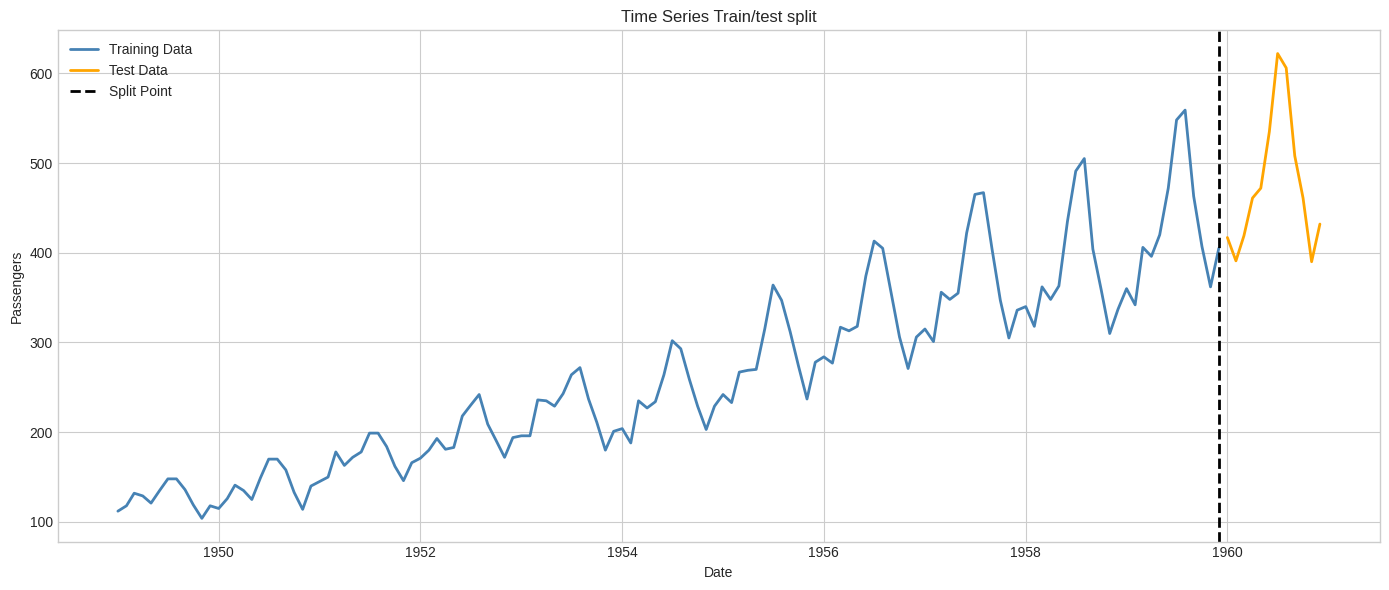

In [25]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(train.index, train, label='Training Data', color='steelblue', linewidth=2)
ax.plot(test.index, test, label='Test Data', color='orange', linewidth=2)
ax.axvline(x = train.index.max(), color='black', linestyle='--', linewidth=2, label='Split Point')

ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.set_title("Time Series Train/test split")
ax.legend()

plt.tight_layout()
plt.show()

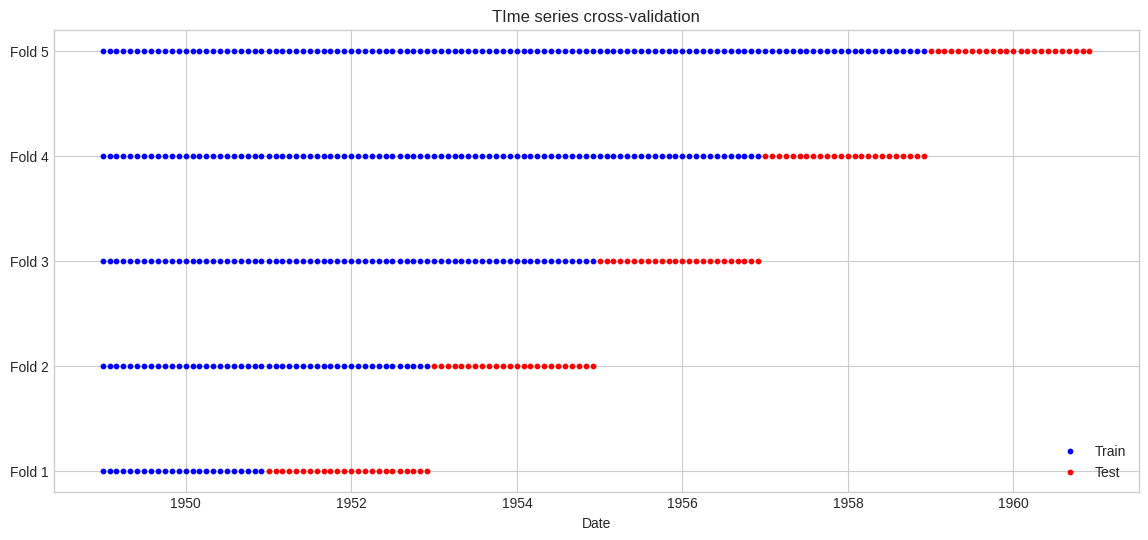

In [29]:
#Time series cross validation
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

fig, ax = plt.subplots(figsize=(14, 6))

for i, (train_idx, test_idx) in enumerate(tscv.split(df['passengers'])):
  train_dates = df.index[train_idx]
  test_dates = df.index[test_idx]

  ax.scatter(train_dates, [i] * len(train_dates), c='blue', s=10, label='Train' if i == 0 else '')
  ax.scatter(test_dates, [i] * len(test_dates), s=10, label='Test' if i == 0 else '', c='red')

ax.set_yticks(range(5))
ax.set_yticklabels([f'Fold {i+1}' for i in range(5)])
ax.set_xlabel("Date")
ax.set_title("TIme series cross-validation")
ax.legend()

Simple forecasting with lag features

In [30]:
#Prepare features for a simple model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Create feautures
df_model = df[['passengers']].copy()
df_model['lag_1'] = df_model['passengers'].shift(1)
df_model['lag_12'] = df_model['passengers'].shift(12)
df_model['month'] = df_model.index.month

#drop NaN
df_model = df_model.dropna()

print(f"{len(df_model)} samples")
df_model.head()

132 samples


,passengers,lag_1,lag_12,month
month,,,,
1950-01-01,115,118.0,112.0,1
1950-02-01,126,115.0,118.0,2
1950-03-01,141,126.0,132.0,3
1950-04-01,135,141.0,129.0,4
1950-05-01,125,135.0,121.0,5


In [32]:
#Temporal split
train_size = int(len(df_model) * 0.8)

train_data = df_model.iloc[:train_size]
test_data = df_model.iloc[train_size:]

x_train = train_data[['lag_1', 'lag_12', 'month']]
y_train = train_data['passengers']

x_test = test_data[['lag_1', 'lag_12', 'month']]
y_test = test_data['passengers']

print(f"Training: {len(x_train)} samples")
print(f"Testing: {len(x_test)} samples")

Training: 105 samples
Testing: 27 samples


In [35]:
#Training a simple Linear regression
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")

Results:
MAE: 15.53
RMSE: 18.68
MAPE: 3.69


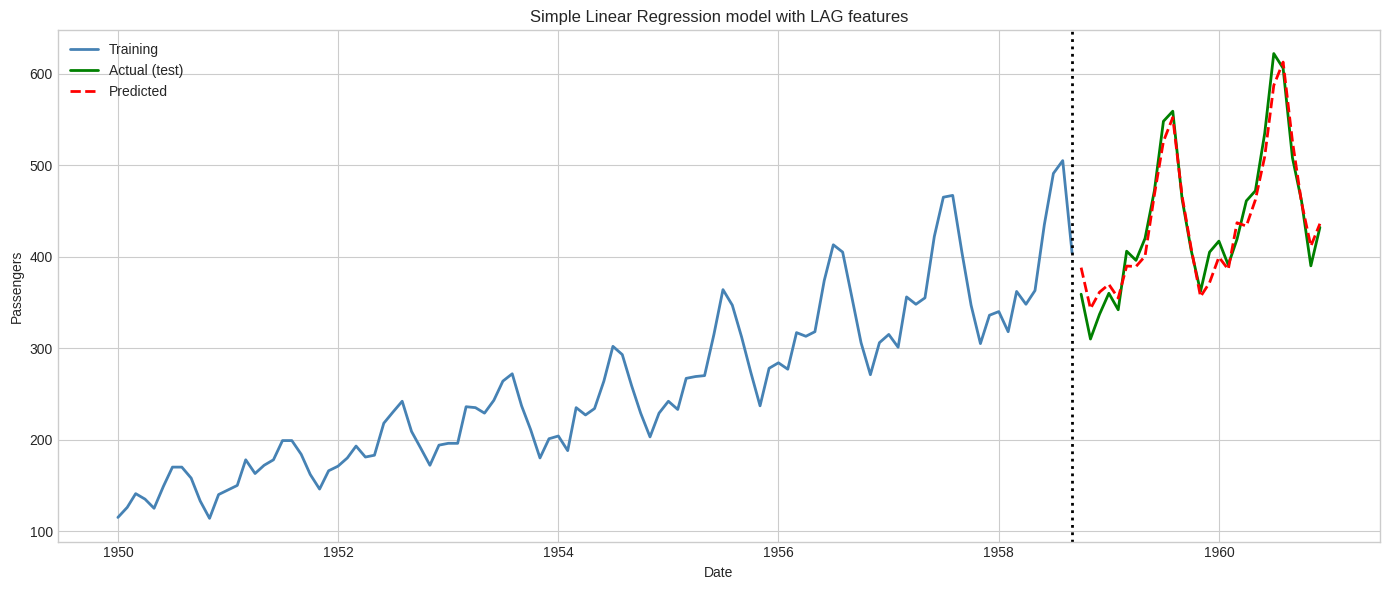

In [36]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(train_data.index, y_train, label='Training', color='steelblue', linewidth=2)
ax.plot(test_data.index, y_test, label='Actual (test)', color='green', linewidth=2)
ax.plot(test_data.index, y_pred, label='Predicted', color='red', linewidth=2, linestyle='--')

ax.axvline(x=train_data.index[-1], color='black', linestyle=':', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.set_title(f"Simple Linear Regression model with LAG features")

ax.legend()
plt.tight_layout()
plt.show()

In [38]:
#Feature Importance
importance = pd.DataFrame({
    'Feature': ['Lag_1', 'Lag_12', 'month'],
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Feature Importance")
print(importance.to_string(index=False))



Feature Importance
Feature  Coefficient
 Lag_12     0.871707
  Lag_1     0.182877
  month    -0.001772


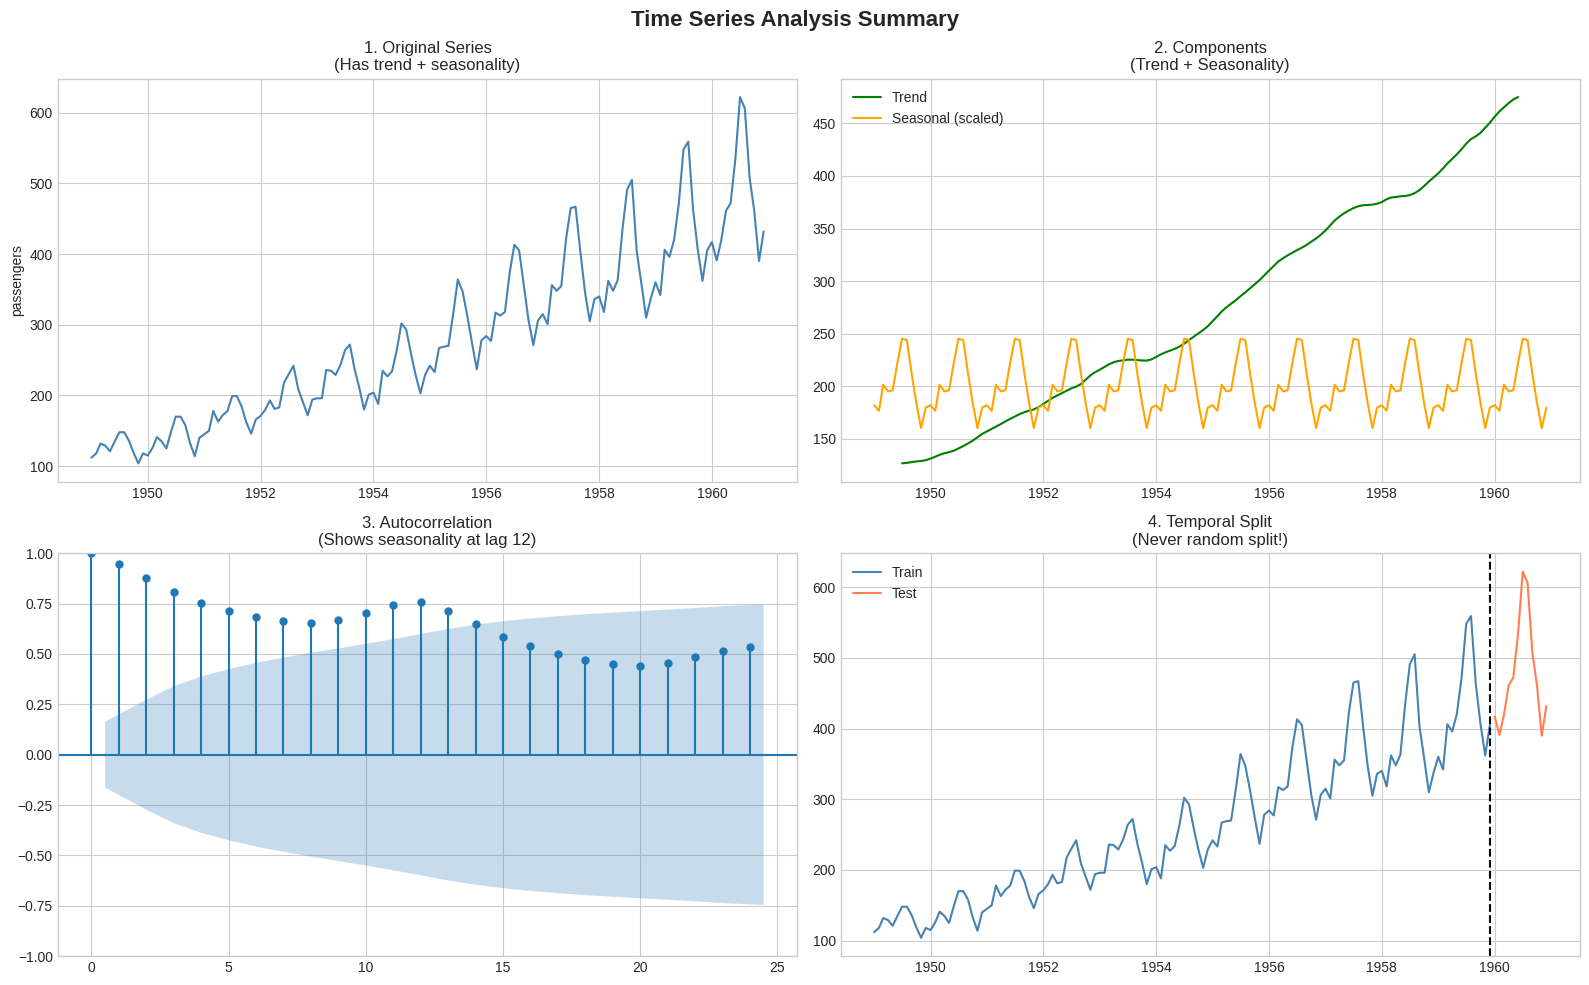

In [39]:
#%%
# Create summary visualization
fig = plt.figure(figsize=(16, 10))

# Main time series
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(df.index, df['passengers'], color='steelblue')
ax1.set_title('1. Original Series\n(Has trend + seasonality)')
ax1.set_ylabel('passengers')

# Decomposition
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(df.index, decomposition.trend, label='Trend', color='green')
ax2.plot(df.index, decomposition.seasonal * 200, label='Seasonal (scaled)', color='orange')
ax2.set_title('2. Components\n(Trend + Seasonality)')
ax2.legend()

# ACF
ax3 = fig.add_subplot(2, 2, 3)
plot_acf(df['passengers'], lags=24, ax=ax3)
ax3.set_title('3. Autocorrelation\n(Shows seasonality at lag 12)')

# Train/Test Split
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(train.index, train, label='Train', color='steelblue')
ax4.plot(test.index, test, label='Test', color='coral')
ax4.axvline(x=train.index[-1], color='black', linestyle='--')
ax4.set_title('4. Temporal Split\n(Never random split!)')
ax4.legend()

plt.suptitle('Time Series Analysis Summary', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## Key Takeaways from Day 13

### Time Series Components:

| Component | What It Is | How to Handle |
|-----------|------------|---------------|
| **Trend** | Long-term direction | Differencing, detrending |
| **Seasonality** | Regular patterns | Seasonal differencing, seasonal features |
| **Residual** | Random noise | What's left after removing trend + season |

### Stationarity:

| Test | Null Hypothesis | Stationary If |
|------|-----------------|---------------|
| **ADF Test** | Has unit root (non-stationary) | p < 0.05 |
| **KPSS Test** | Is stationary | p > 0.05 |

### Key Features for Forecasting:

| Feature Type | Examples |
|--------------|----------|
| **Lag features** | Lag_1, Lag_12 (same period last year) |
| **Rolling stats** | Rolling mean, std, min, max |
| **Date features** | Month, day of week, quarter |
| **Expanding stats** | Cumulative mean, sum |

### Golden Rules:

```
1. NEVER shuffle time series data
2. ALWAYS use temporal train/test split
3. Check stationarity before modeling
4. ACF/PACF help identify model order
5. Lag_12 often most important for monthly data


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
import os
path = '/content/drive/MyDrive/100-days-of-ml/phase-1-data-foundations/day-13-time-series-basics'
os.makedirs(path, exist_ok=True)
print(f'Folder created: {path}')

Folder created: /content/drive/MyDrive/100-days-of-ml/phase-1-data-foundations/day-13-time-series-basics
